## Import libraries

In [2]:
import re 
import pytesseract
import cv2
import numpy as np
import json
import matplotlib.pyplot as plt
from PIL import Image

## Load & Display Image

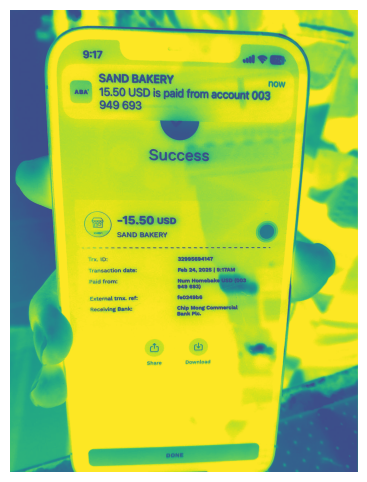

In [3]:
image_path = "preprocessed_photo_2025-03-24 23.35.50.jpeg"
image = Image.open(image_path)

# Display Image
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.axis("off")
plt.show()

## Preprocess Image

In [6]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)

    # OPTIONAL: Crop to focus only on the transaction detail area (manually adjust if needed)
    # Format: [y1:y2, x1:x2] - adjust depending on layout
    cropped_img = img[300:700, 50:600]  # Example cropping, adjust for your layout

    # Convert to grayscale
    gray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)

    # Resize (zoom in 2x)
    zoomed = cv2.resize(gray, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)

    # Apply threshold to make text sharper
    _, thresh = cv2.threshold(zoomed, 150, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # OPTIONAL: Apply sharpening kernel
    kernel = np.array([[0, -1, 0],
                       [-1,  5,-1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(thresh, -1, kernel)

    # Convert back to PIL Image for Tesseract
    return Image.fromarray(sharpened)

image = preprocess_image("preprocessed_photo_2025-03-24 23.35.50.jpeg")
text = pytesseract.image_to_string(image)
print(text)

preprocess = preprocess_image(image_path)
# plt.figure(figsize=(8, 6))
# plt.imshow(preprocess, cmap="gray")
# plt.axis("off")
# plt.show()

## Apply OCR to Extract Text

In [8]:
def extract_text_from_image(image) -> str:
    """Extracts text from an image using Tesseract OCR."""

    # Apply OCR with PSM mode (6 for multi-column detection)
    custom_config = r'--oem 3 --psm 6'  # Try changing to --psm 4 if results are still wrong
    extracted_text = pytesseract.image_to_string(image, config=custom_config)
    
    return extracted_text.strip()

# Extract Text
extracted_text = extract_text_from_image("preprocessed_photo_2025-03-24 23.35.50.jpeg")
print("Extracted Text:\n", extracted_text)

Extracted Text:
 | SAND BAKERY ii
Success inion
—— ~~
(‘@) -15.50 usp og _—_—
“7 SAND BAKERY eS Hl
A Transaction date: Feb 24, 2025 | ‘S217AM . a : !
y Paid from: Num —_— - f
i s — External trnx. ref: fe0249b6 —

; qq ' Receiving Bank: Chip Hone: Commercias |

Share Download [ag -


## Classify Bank

In [12]:
def classify_bank(extracted_text: str) -> str:
    """Classifies the bank based on keywords in the extracted text."""
    bank_keywords = {
        "ABA Bank": ["ABA' BANK", "NATIONAL BANK OF CANADA GROUP"]
    }
    
    # Check for keywords in extracted text
    for bank, keywords in bank_keywords.items():
        for keyword in keywords:
            if keyword.lower() in extracted_text.lower():
                return bank
    return "Unknown Bank"

# Identify Bank
bank_name = classify_bank(extracted_text)
print(f"Identified Bank: {bank_name}")

Identified Bank: Unknown Bank


## Extract Key Transaction Details

In [13]:
def extract_transaction_data(extracted_text: str) -> dict:
    """Extracts transaction details using regex."""
    
    patterns = {
        "transaction_id": r"Trx. ID: (\d+)",
        "amount": r"Original amount: (\d+\.\d+)",
        "date": r"Transaction date: (.+)"
    }
    
    extracted_data = {}
    
    for key, pattern in patterns.items():
        match = re.search(pattern, extracted_text)
        
        if match:
            extracted_data[key] = match.group(1)
        else:
            extracted_data[key] = "None"
        
    return extracted_data

# Extract Transaction Data
transaction_data = extract_transaction_data(extracted_text)
transaction_data["bank"] = bank_name
print("Extracted Transaction Data:\n", json.dumps(transaction_data, indent=2))

Extracted Transaction Data:
 {
  "transaction_id": "None",
  "amount": "None",
  "date": "None",
  "bank": "Unknown Bank"
}


## Save Results as JSON

In [14]:
output_path = "../data/processed/transaction_data.json"

with open(output_path, "w") as file:
    json.dump(transaction_data, file, indent=2)
    
print(f"Data saved at: {output_path}")

Data saved at: ../data/processed/transaction_data.json
